## Imports

In [38]:
%matplotlib inline

import numpy as np
from delay_calc import delay_signal
from gain_cal import stefcal
from signal_gen import generate_complex_samples
from signal_gen import generate_random_curve
from utls import integrate, plot_result

## Set paramters

In [39]:
# number of antennas
antenna_len = 5
# number of samples 
sample_len = int(1e5)
# number of channels
channel_len = sample_len
# bandwidth of the observation
observe_bandwidth = 2.0e6

## Toggles and corresponding paramters

In [40]:
enable_instrument_noise = True
enable_time_delay = True
enable_phase_noise = True
enable_baseline_fit = True
phase_noise_scale = 5.0e-9
# larger number means more twists
phase_noise_trend = 7
# how different between the means of the phase noise
phase_noise_mean_offsets_scale = 1e-8
instrument_noise_scale = 1e-3
delay_and_scale = np.array([0, 1, 2, 3, 4]) * 1.0e-8
integrate_factor = 10

## Generate original signal, which is the same white noise seen by all elements.

In [41]:
source = generate_complex_samples([sample_len], scale = 1)

## Create the model signal

In [42]:
# fill the same model signal to each antenna
source_array = np.tile(source, (antenna_len, 1))

## Channelize the model signal

In [43]:
channellized_model = np.fft.fft(source_array)

## Create visibilites (cross correlation product of all possible antenna pairs)

In [44]:
# row-wise outer product
model_visibilities = np.einsum('ik,jk->ijk', channellized_model, channellized_model.conj())

## Phase of the model visibilites of one baseline

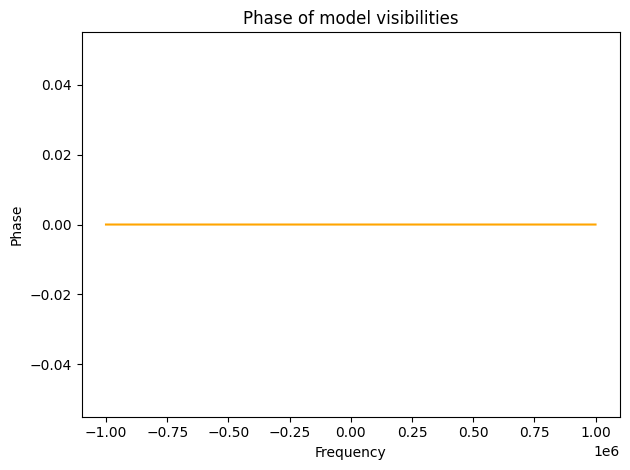

In [45]:
model_phases = np.angle(model_visibilities[0, 4])
fft_freq = np.fft.fftfreq(sample_len, 1/observe_bandwidth)
fft_freq_shifted = np.fft.fftshift(fft_freq)
plot_result(fft_freq_shifted, np.fft.fftshift(model_phases),
            None, None,
            "Model", None, "Phase of model visibilities")


## Add instrument noise

In [46]:
# create the instrument noise
instrument_noise_scale = 1e-3
instrument_noise = (generate_complex_samples(
        [antenna_len, sample_len], scale = instrument_noise_scale)
        if enable_instrument_noise else 0)

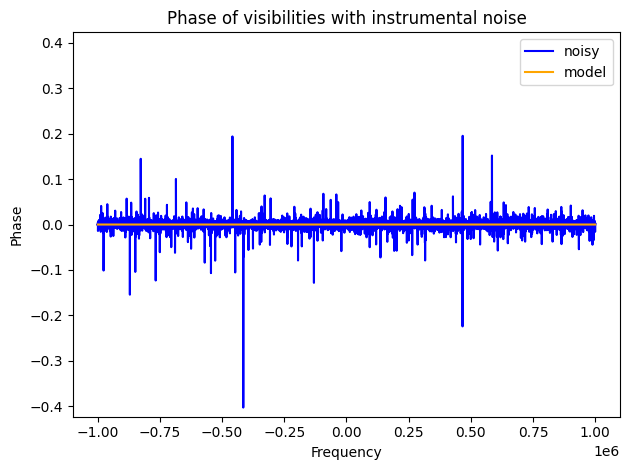

In [47]:
# add the instrument noise to the model signal
signal = source_array + instrument_noise
channellized_signal = np.fft.fft(signal)
visibilities = np.einsum('ik,jk->ijk', channellized_signal, channellized_signal.conj())
phases = np.angle(visibilities[0, 4])
plot_result(fft_freq_shifted, np.fft.fftshift(phases),
            fft_freq_shifted, np.fft.fftshift(model_phases),
            "noisy", "model", "Phase of visibilities with instrumental noise")

## Add delay + intrument noise

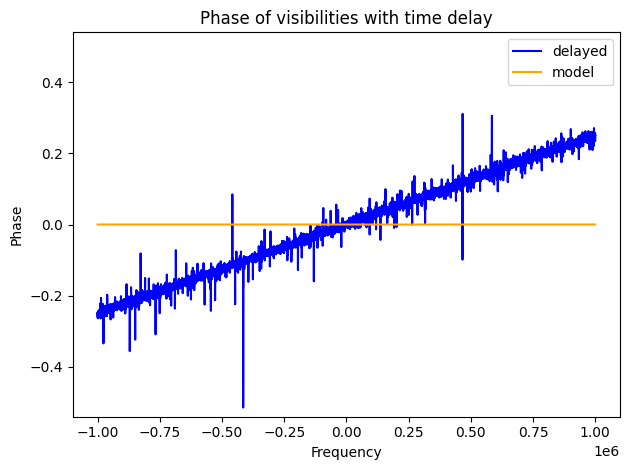

In [48]:
# add the time delay and instrument noise to the model signal
time_delay = delay_and_scale if enable_time_delay else 0
signal = (delay_signal(source_array, time_delay, observe_bandwidth,
            1, noise = 0) + instrument_noise)
channellized_signal = np.fft.fft(signal)
visibilities = np.einsum('ik,jk->ijk', channellized_signal, channellized_signal.conj())
phases = np.angle(visibilities[0, 4])

plot_result(fft_freq_shifted, np.unwrap(np.fft.fftshift(phases)),
            fft_freq_shifted, np.fft.fftshift(model_phases),
            "delayed", "model", "Phase of visibilities with time delay")

## Add phase noise + delay + intrument noise

In [49]:
# create the phase curve through out the bandpass
phase_noise_mean = (np.random.uniform(0, np.pi*2, antenna_len)              
                * phase_noise_mean_offsets_scale)
random_phase_curve = generate_random_curve(channel_len, phase_noise_trend,
        phase_noise_mean, phase_noise_scale)

In [50]:
# create the phase noise shifter from the random phase curve
phase_noise = (np.exp(-1j * 2 * np.pi * random_phase_curve * fft_freq)
        if enable_phase_noise else 0)

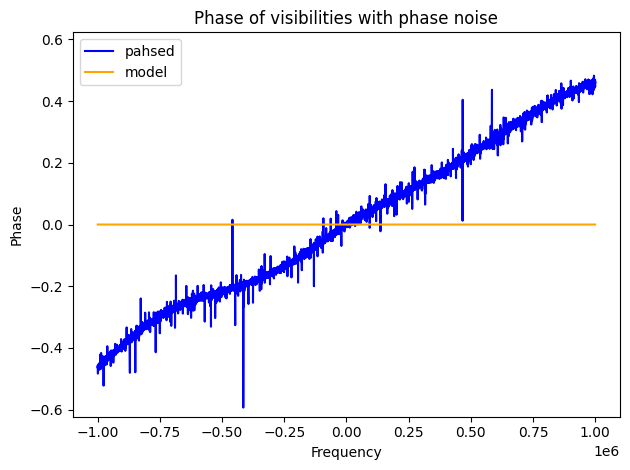

In [51]:
# add the time delay, instrument noise and phase noise to the model signal
signal = (delay_signal(source_array, time_delay, observe_bandwidth,
            1, noise = phase_noise) + instrument_noise)
channellized_signal = np.fft.fft(signal)
visibilities = np.einsum('ik,jk->ijk', channellized_signal, channellized_signal.conj())
phases = np.angle(visibilities[0, 4])

plot_result(fft_freq_shifted, np.unwrap(np.fft.fftshift(phases)),
            fft_freq_shifted, np.fft.fftshift(model_phases),
            "pahsed", "model", "Phase of visibilities with phase noise")

## Integrate the visibilities to reduce the instrument noise

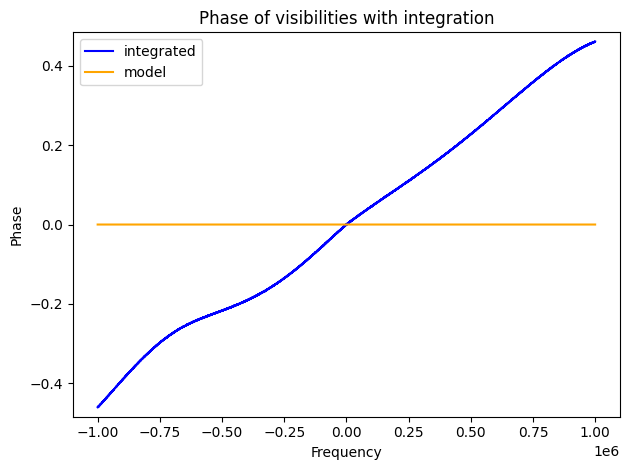

In [52]:
integrated_visibilities = integrate(visibilities, integrate_factor)
integrated_model_visibilities = integrate(model_visibilities, integrate_factor)
fft_freq_shifted = np.fft.fftshift(
        np.fft.fftfreq(int(channel_len/integrate_factor), 1/observe_bandwidth))
phases = np.fft.fftshift(np.angle(integrated_visibilities[0, 4]))
model_phases = np.fft.fftshift(np.angle(integrated_model_visibilities[0, 4]))
plot_result(fft_freq_shifted, np.unwrap(phases),
            fft_freq_shifted, model_phases,
            "integrated", "model", "Phase of visibilities with integration")


## Fit the slope to evaluate the time delay

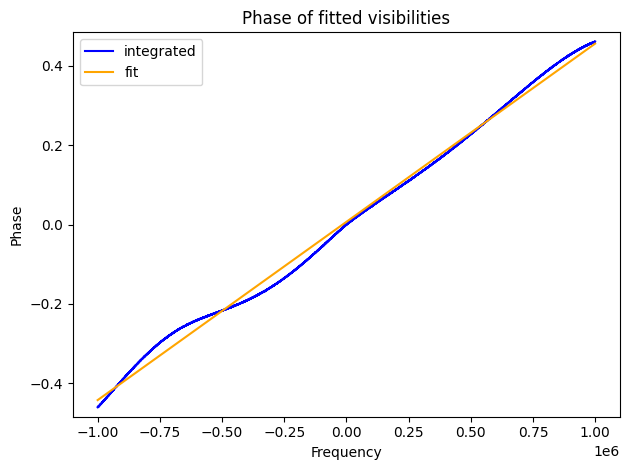

In [53]:
# fit the slope of the integrated phase
if enable_baseline_fit:
    conef = np.polyfit(fft_freq_shifted, np.unwrap(phases), deg=1)
    fitted_phases = np.polyval(conef, fft_freq_shifted)
else:
    fitted_phases = np.zeros_like(phases)
plot_result(fft_freq_shifted, np.unwrap(phases),
            fft_freq_shifted, fitted_phases,
            "integrated", "fit", "Phase of fitted visibilities")

## Flatten the slope to reduce the time delay

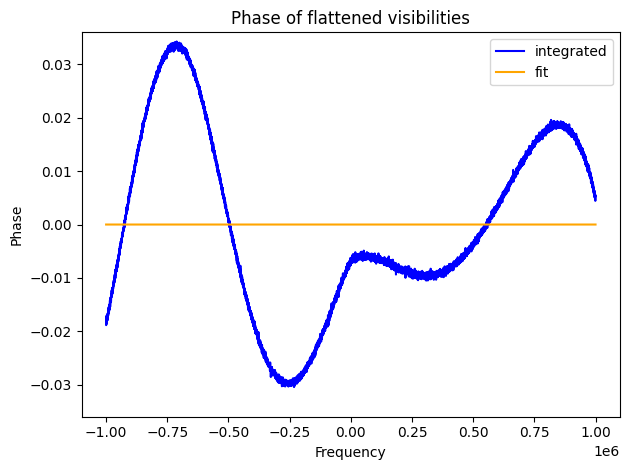

In [54]:
# flatten the integrated visibilities
flattened_integrated_visibilities = (integrated_visibilities
        * np.exp(-1j * fitted_phases))
#  flattened_phases = np.angle(flattened_integrated_visibilities[0,4])
flattened_phases = phases - fitted_phases
plot_result(fft_freq_shifted, np.unwrap(flattened_phases),
            fft_freq_shifted, model_phases,
            "integrated", "fit", "Phase of flattened visibilities")

## Weight the visibilities to reduce the phase noise

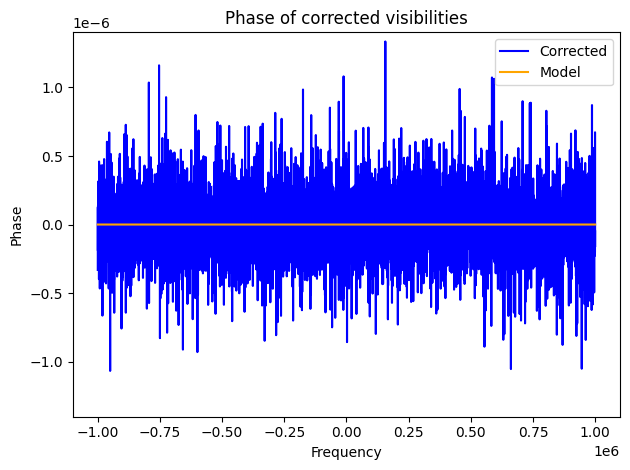

In [55]:
corrected_visibilities = np.zeros_like(integrated_model_visibilities)
# correct the visibilities accross frequencies
for channel_index in range(len(fft_freq_shifted)):
    # calculate per antenna gain
    gains = stefcal(
            flattened_integrated_visibilities[:, :, channel_index],
            integrated_model_visibilities[:, :, channel_index], niter=100)
    per_antenna_gain = gains[0]
    # create the correction matrix from the antenna gains
    correction_matrix  = np.outer(np.conj(per_antenna_gain), per_antenna_gain)
    # normalize the visibilities to the first antenna
    flattened_integrated_visibilities[:, :, channel_index] *= (
            np.conj(flattened_integrated_visibilities[0, 0, channel_index])
            / np.abs(flattened_integrated_visibilities [0, 0, channel_index]))
    # weight the visibilities using the correction matrix
    corrected_visibilities[:, :, channel_index] = (correction_matrix**(-1)
            * flattened_integrated_visibilities[:, :, channel_index])
corrected_phases = np.angle(corrected_visibilities[0, 4])
plot_result(fft_freq_shifted, corrected_phases,
        fft_freq_shifted, model_phases,
        "Corrected", "Model", "Phase of corrected visibilities")

## References

- [Calibration as a Least Squares Problem](https://github.com/ratt-ru/foi-course/blob/master/8_Calibration/8_1_calibration_least_squares_problem.ipynb)

- [Salvini, S. and Wijnholds, S. J., “Fast gain calibration in radio astronomy using alternating direction implicit methods: Analysis and applications”, Astronomy and Astrophysics, vol. 571, Art. no. A97, 2014. doi:10.1051/0004-6361/201424487.](https://doi.org/10.1051/0004-6361/201424487)

- [Principles of Interferometry](https://www3.mpifr-bonn.mpg.de/staff/hrk/AIPS_TUTORIAL/IMPRS_BB_HRK5.pdf)

- [Directional Calibration of LOFAR data](https://fse.studenttheses.ub.rug.nl/13098/1/Bachelor_Thesis_Nikki_Arendse.pdf)

- [Thompson, A.R., Moran, J.M., Swenson, G.W. (2017). Calibration and Imaging. In: Interferometry and Synthesis in Radio Astronomy. Astronomy and Astrophysics Library. Springer, Cham. https://doi.org/10.1007/978-3-319-44431-4_10](https://doi.org/10.1007/978-3-319-44431-4_10)

- [Taylor, G. B., Carilli, C. L., and Perley, R. A., “Synthesis Imaging in Radio Astronomy II”, 1999, vol. 180.](https://leo.phys.unm.edu/~gbtaylor/astr423/s98book.pdf)
